# Fine-Tuning

In [ ]:
logdir = os.path.join("logs", "my_model")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout

from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
MODELS_PATH="/content/drive/MyDrive/Lab-Proj/models/"

In [ ]:
input_shape = (IMG_SIZE,IMG_SIZE,3)
MODEL_PATH=f"{MODELS_PATH}EfficientNetV2B0-age-k=3.h5"

In [ ]:
data_augmentation = tf.keras.Sequential([ tf.keras.layers.RandomFlip(mode="horizontal", seed=42), tf.keras.layers.RandomRotation(factor=0.05, seed=42), tf.keras.layers.RandomContrast(factor=0.2, seed=42) ])# tf.keras.Sequential([ tf.keras.layers.RandomFlip('horizontal'), tf.keras.layers.RandomRotation(0.2), ])

## Layers Freezing

24274472/24274472 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-b0 (Function  (None, 7, 7, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                              

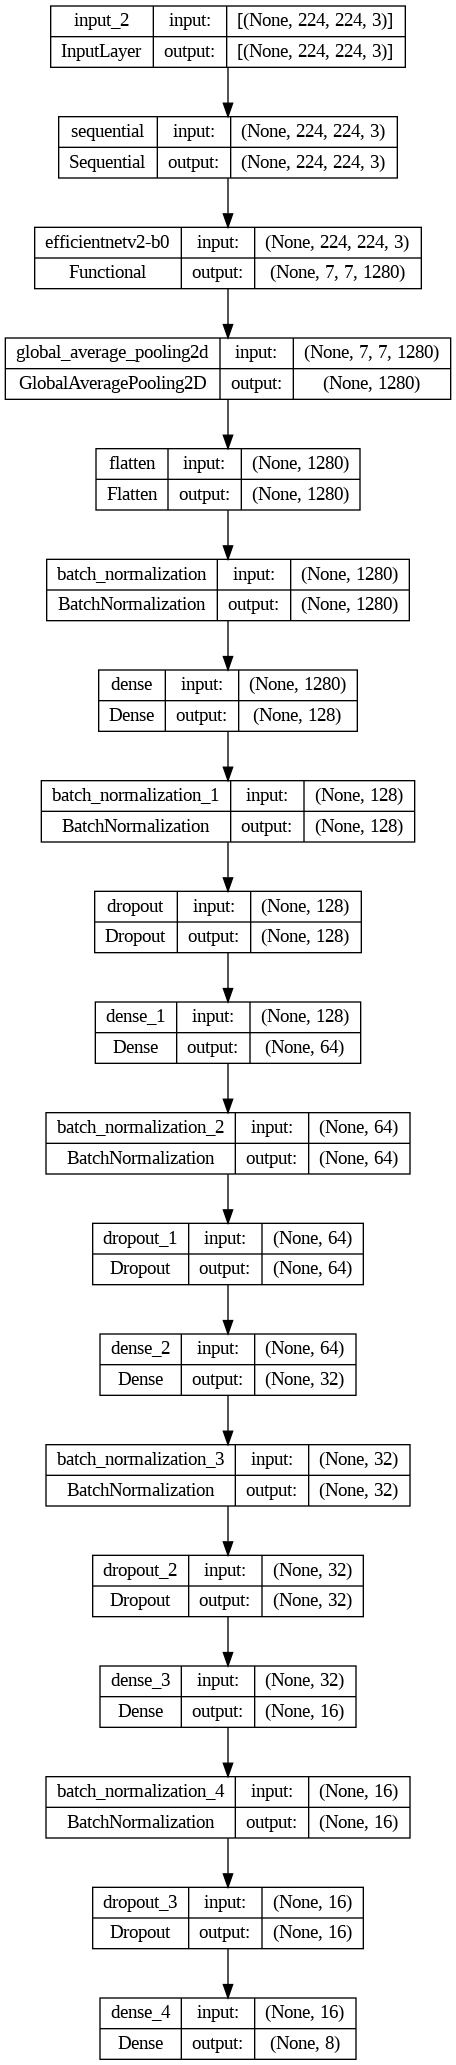

In [ ]:
# %%script false --no-raise-error
from keras import layers
from keras import regularizers

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(input_shape=input_shape, weights="imagenet",include_top=False)

for layer in base_model.layers:
  layer.trainable = False

inputs = tf.keras.Input(shape=input_shape)
x = data_augmentation(inputs)

x = tf.keras.applications.efficientnet_v2.preprocess_input(x)

x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)
#kernel_constraint=tf.keras.constraints.max_norm(1.)
# x = tf.keras.layers.Dense(512, activation="relu", kernel_initializer="he_normal", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Dropout(.1)(x)


x = tf.keras.layers.Dense(128, activation="relu", kernel_initializer="he_normal")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(.2)(x)


x = tf.keras.layers.Dense(64, activation="relu", kernel_initializer="he_normal")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(.2)(x)


x = tf.keras.layers.Dense(32, activation="relu", kernel_initializer="he_normal")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(.2)(x)


x = tf.keras.layers.Dense(16, activation="relu", kernel_initializer="he_normal")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(.2)(x)
prediction_layer = tf.keras.layers.Dense(units = n_classes, activation='softmax')

outputs = prediction_layer(x) 
model = tf.keras.Model(inputs, outputs)
model.summary()

tf.keras.utils.plot_model(model, to_file="/content/img_model_age.png", show_shapes=True)


In [ ]:
checkpoint_filepath = MODEL_PATH
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_top_k_categorical_accuracy',
    mode='max',
    save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)


## Tuning

In [ ]:
%%script false --no-raise-error

model = keras.models.load_model(MODEL_PATH)
for layer in model.layers:
  layer.trainable = False


for layer in model.layers[-15:]:
  layer.trainable = True

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""
: Optimizer
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, clipvalue=1.0)

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""                               
: Loss Fn
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""                               
# lossfn = tf.keras.losses.BinaryCrossentropy()

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""
: Model Summary
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[tf.keras.metrics.TopKCategoricalAccuracy(k=3)])

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""
: Training
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""

history = model.fit(train_generator, 
                  verbose=1, 
                  validation_data=val_generator,
                  epochs=100,
                  batch_size=BATCH_SIZE, callbacks = [model_checkpoint_callback, es])

In [ ]:
# %tensorboard --logdir logs
# ! tensorboard dev upload \
#   --logdir logs \
#   --name "Age Classification 3 Classification EfficientNetV2S" \
#   --description "Training results from EfficientNetV2S"  \
#   --one_shot

In [ ]:
score = model.evaluate(test_generator)

RuntimeError: ignored